In [1]:
import os
import numpy as np
import threading as thr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten, InputLayer, Activation, Dropout
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import SGD

In [2]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [3]:
mammo_o, mammo_f, label = [], [], []
data_folder = "../dataset/"
os.chdir(data_folder)
l = os.listdir()

In [4]:
def create_dataset(lista, o_img, f_img, labels):
    #Function calling the Matlab file in order to filter the images.
    for element in lista:
        if "_1_resized.pgm" in element:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(data_folder, element)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            labels.append(1)
        elif "_2_resized.pgm" in element:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(data_folder, element)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            labels.append(0)

In [5]:
os.chdir("./")
threads = []
chunk = 6

for i in range(49):
    t = thr.Thread(target = create_dataset, args = (l[i*chunk : (i+1)*chunk], mammo_o, mammo_f, label))
    threads.append(t)
    t.start()
    
for j in threads:
    j.join()

In [6]:
mammo_o = np.asarray(mammo_o, dtype = 'float32')/255.
mammo_f = np.asarray(mammo_f, dtype = 'float32')/255.
label = np.asarray(label)
mammo_o_4d = np.reshape(mammo_o, (147, 125, 125, 1))
print(mammo_o_4d.shape)
mammo_f_4d = np.reshape(mammo_f, (147, 64, 64, 1))
print(mammo_f_4d.shape)

(147, 125, 125, 1)
(147, 64, 64, 1)


In [7]:
def cnn_o(shape=(125, 125, 1)):
    model = Sequential([
        
        Conv2D(4, (3,3), padding = 'same', input_shape = shape),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        Dropout(0.1),
        
        
        Conv2D(8, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        #Dropout(0.2),
        
        
        Conv2D(10, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        Dropout(0.2),
        
        Flatten(),
        
        Dense(10, activation = 'relu'),
        #Dropout(0.1),
        Dense(1, activation = 'sigmoid')        
        
    ])
    
    return model

In [8]:
model_o = cnn_o()
model_o.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 4)       40        
                                                                 
 batch_normalization (BatchN  (None, 125, 125, 4)      16        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 125, 125, 4)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 4)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 4)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 8)         2

In [9]:
learning_rate = 0.001
model_o.compile(optimizer = SGD(learning_rate, momentum = 0.9), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [10]:
reduce_on_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

In [11]:
X_train_o, X_val_o, Y_train_o, Y_val_o = train_test_split(mammo_o_4d, label, test_size = 0.2, random_state = 44)
batch_size = 21
train_o = model_o.fit(X_train_o, Y_train_o,
                     batch_size = batch_size,
                     epochs = 260, 
                     verbose = 1,
                     validation_data = (X_val_o, Y_val_o),
                     callbacks = [reduce_on_plateau])    

Epoch 1/260
6/6 [==============================] - 4s 263ms/step - loss: 0.8360 - accuracy: 0.3761 - val_loss: 0.6927 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 2/260
6/6 [==============================] - 1s 110ms/step - loss: 0.6885 - accuracy: 0.5897 - val_loss: 0.6888 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 3/260
6/6 [==============================] - 0s 74ms/step - loss: 0.6685 - accuracy: 0.6325 - val_loss: 0.6873 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 4/260
6/6 [==============================] - 1s 103ms/step - loss: 0.6455 - accuracy: 0.6496 - val_loss: 0.6860 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 5/260
6/6 [==============================] - 1s 113ms/step - loss: 0.6346 - accuracy: 0.6496 - val_loss: 0.6840 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 6/260
6/6 [==============================] - 1s 96ms/step - loss: 0.6254 - accuracy: 0.6496 - val_loss: 0.6819 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 7/260
6/6 [==============================] - 0s 78ms/step - loss: 0.6215

6/6 [==============================] - 1s 111ms/step - loss: 0.5638 - accuracy: 0.6496 - val_loss: 0.7791 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 54/260
6/6 [==============================] - 1s 125ms/step - loss: 0.5531 - accuracy: 0.6496 - val_loss: 0.7781 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 55/260
6/6 [==============================] - 1s 124ms/step - loss: 0.5950 - accuracy: 0.6496 - val_loss: 0.7770 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 56/260
6/6 [==============================] - 0s 74ms/step - loss: 0.5459 - accuracy: 0.6496 - val_loss: 0.7756 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 57/260
6/6 [==============================] - 0s 87ms/step - loss: 0.5530 - accuracy: 0.6496 - val_loss: 0.7744 - val_accuracy: 0.5667 - lr: 1.0000e-08
Epoch 58/260
6/6 [==============================] - 1s 100ms/step - loss: 0.5526 - accuracy: 0.6496 - val_loss: 0.7731 - val_accuracy: 0.5667 - lr: 1.0000e-08
Epoch 59/260
6/6 [==============================] - 1s 136ms/

Epoch 105/260
6/6 [==============================] - 1s 98ms/step - loss: 0.5603 - accuracy: 0.6496 - val_loss: 0.6728 - val_accuracy: 0.5667 - lr: 1.0000e-12
Epoch 106/260
6/6 [==============================] - 0s 60ms/step - loss: 0.5717 - accuracy: 0.6496 - val_loss: 0.6713 - val_accuracy: 0.5667 - lr: 1.0000e-12
Epoch 107/260
6/6 [==============================] - 1s 109ms/step - loss: 0.5844 - accuracy: 0.6581 - val_loss: 0.6698 - val_accuracy: 0.5667 - lr: 1.0000e-12
Epoch 108/260
6/6 [==============================] - 1s 110ms/step - loss: 0.5657 - accuracy: 0.6496 - val_loss: 0.6686 - val_accuracy: 0.5667 - lr: 1.0000e-12
Epoch 109/260
6/6 [==============================] - 1s 100ms/step - loss: 0.5641 - accuracy: 0.6581 - val_loss: 0.6673 - val_accuracy: 0.5667 - lr: 1.0000e-12
Epoch 110/260
6/6 [==============================] - 1s 132ms/step - loss: 0.5678 - accuracy: 0.6496 - val_loss: 0.6662 - val_accuracy: 0.5667 - lr: 1.0000e-12
Epoch 111/260
6/6 [=======================

6/6 [==============================] - 1s 186ms/step - loss: 0.5497 - accuracy: 0.6496 - val_loss: 0.6446 - val_accuracy: 0.5667 - lr: 1.0000e-12
Epoch 157/260
6/6 [==============================] - 1s 194ms/step - loss: 0.5623 - accuracy: 0.6496 - val_loss: 0.6444 - val_accuracy: 0.5667 - lr: 1.0000e-12
Epoch 158/260
6/6 [==============================] - 1s 197ms/step - loss: 0.5713 - accuracy: 0.6496 - val_loss: 0.6442 - val_accuracy: 0.5667 - lr: 1.0000e-12
Epoch 159/260
6/6 [==============================] - 1s 125ms/step - loss: 0.5551 - accuracy: 0.6581 - val_loss: 0.6440 - val_accuracy: 0.5667 - lr: 1.0000e-12
Epoch 160/260
6/6 [==============================] - 1s 104ms/step - loss: 0.5627 - accuracy: 0.6496 - val_loss: 0.6439 - val_accuracy: 0.5667 - lr: 1.0000e-12
Epoch 161/260
6/6 [==============================] - 1s 126ms/step - loss: 0.5700 - accuracy: 0.6496 - val_loss: 0.6438 - val_accuracy: 0.5667 - lr: 1.0000e-12
Epoch 162/260
6/6 [==============================] - 1

6/6 [==============================] - 1s 127ms/step - loss: 0.5637 - accuracy: 0.6410 - val_loss: 0.6434 - val_accuracy: 0.5667 - lr: 1.0000e-14
Epoch 208/260
6/6 [==============================] - 1s 180ms/step - loss: 0.5618 - accuracy: 0.6496 - val_loss: 0.6434 - val_accuracy: 0.5667 - lr: 1.0000e-14
Epoch 209/260
6/6 [==============================] - 1s 128ms/step - loss: 0.5597 - accuracy: 0.6581 - val_loss: 0.6431 - val_accuracy: 0.5667 - lr: 1.0000e-14
Epoch 210/260
6/6 [==============================] - 1s 133ms/step - loss: 0.5530 - accuracy: 0.6496 - val_loss: 0.6430 - val_accuracy: 0.5667 - lr: 1.0000e-14
Epoch 211/260
6/6 [==============================] - 1s 126ms/step - loss: 0.5738 - accuracy: 0.6496 - val_loss: 0.6428 - val_accuracy: 0.5667 - lr: 1.0000e-14
Epoch 212/260
6/6 [==============================] - 1s 132ms/step - loss: 0.5685 - accuracy: 0.6410 - val_loss: 0.6426 - val_accuracy: 0.5667 - lr: 1.0000e-14
Epoch 213/260
6/6 [==============================] - 1

6/6 [==============================] - 1s 124ms/step - loss: 0.5584 - accuracy: 0.6496 - val_loss: 0.6431 - val_accuracy: 0.5667 - lr: 1.0000e-18
Epoch 259/260
6/6 [==============================] - 1s 141ms/step - loss: 0.5636 - accuracy: 0.6581 - val_loss: 0.6429 - val_accuracy: 0.5667 - lr: 1.0000e-18
Epoch 260/260
6/6 [==============================] - 1s 134ms/step - loss: 0.5592 - accuracy: 0.6496 - val_loss: 0.6428 - val_accuracy: 0.5667 - lr: 1.0000e-18


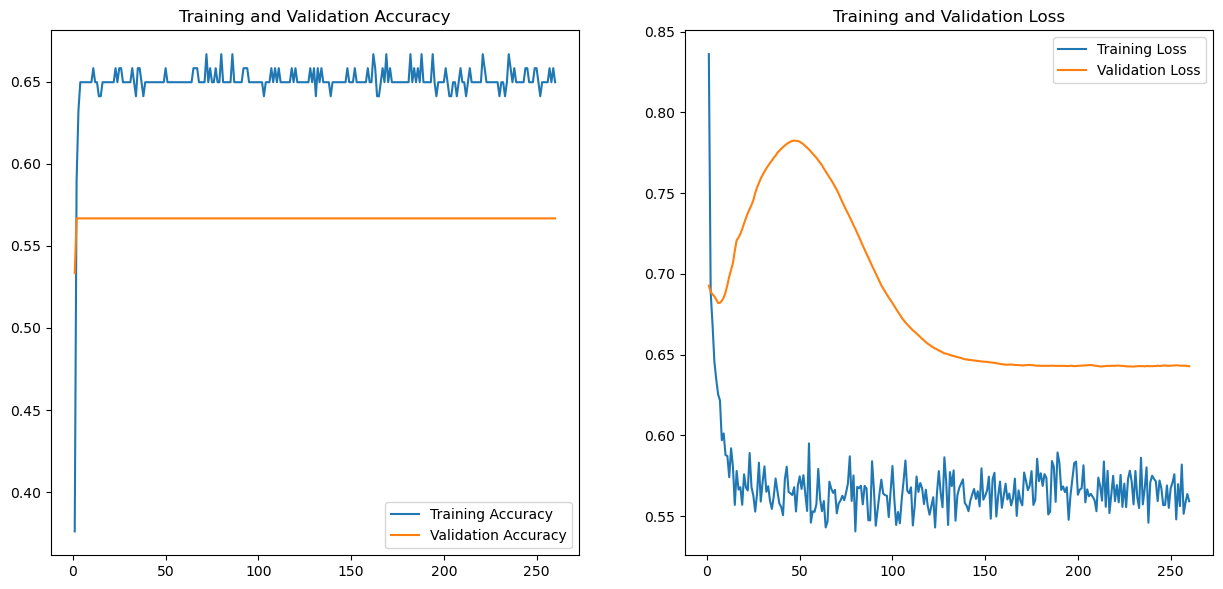

In [12]:
acc = train_o.history['accuracy']
val_acc = train_o.history['val_accuracy']
loss = train_o.history['loss']
val_loss = train_o.history['val_loss']

epochs_range = range(1, len(acc)+1)

#Train and validation accuracy 
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Train and validation loss 
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
def cnn_o_aug(shape=(125, 125, 1)):
    model = Sequential([
        
        Conv2D(6, (3,3), padding = 'same', input_shape = shape),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        Dropout(0.1),
        
        
        Conv2D(8, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        #Dropout(0.2),
        
        
        Conv2D(10, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        Dropout(0.2),
        
        Flatten(),
        
        Dense(10, activation = 'relu'),
        #Dropout(0.1),
        Dense(1, activation = 'sigmoid')        
        
    ])
    
    return model

In [14]:
model_o_aug = cnn_o_aug()
model_o_aug.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 125, 125, 6)       60        
                                                                 
 batch_normalization_3 (Batc  (None, 125, 125, 6)      24        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 125, 125, 6)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 60, 60, 6)        0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 60, 60, 6)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 8)        

In [15]:
learning_rate = 0.001
model_o_aug.compile(optimizer = SGD(learning_rate, momentum = 0.9), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [16]:
from keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
                rotation_range = 90,
                horizontal_flip = True,
                vertical_flip = True,
                validation_split = 0.20)

aug_train_o = aug.flow(mammo_o_4d, label, batch_size = 30, subset = 'training')
aug_val_o = aug.flow(mammo_o_4d, label, batch_size = 30, subset = 'validation')

In [17]:
batch_size = 42
train_o_aug = model_o_aug.fit(aug_train_o, 
                     batch_size = batch_size,
                     epochs = 260, 
                     verbose = 1,
                     validation_data = aug_val_o,
                     callbacks = [reduce_on_plateau])    

Epoch 1/260
4/4 [==============================] - 4s 448ms/step - loss: 1.6973 - accuracy: 0.3814 - val_loss: 0.6928 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 2/260
4/4 [==============================] - 1s 304ms/step - loss: 0.7274 - accuracy: 0.5593 - val_loss: 0.6982 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 3/260
4/4 [==============================] - 1s 229ms/step - loss: 0.7784 - accuracy: 0.6695 - val_loss: 0.6956 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 4/260
4/4 [==============================] - 1s 231ms/step - loss: 0.6661 - accuracy: 0.6610 - val_loss: 0.6963 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 5/260
4/4 [==============================] - 1s 269ms/step - loss: 0.6442 - accuracy: 0.6525 - val_loss: 0.6957 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 6/260
4/4 [==============================] - 1s 248ms/step - loss: 0.6685 - accuracy: 0.6610 - val_loss: 0.6961 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 7/260
4/4 [==============================] - 1s 234ms/step - loss: 0.6

Epoch 53/260
4/4 [==============================] - 1s 182ms/step - loss: 0.5735 - accuracy: 0.6610 - val_loss: 0.7043 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 54/260
4/4 [==============================] - 1s 181ms/step - loss: 0.6080 - accuracy: 0.6610 - val_loss: 0.7057 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 55/260
4/4 [==============================] - 1s 190ms/step - loss: 0.5723 - accuracy: 0.6610 - val_loss: 0.7018 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 56/260
4/4 [==============================] - 1s 221ms/step - loss: 0.5870 - accuracy: 0.6610 - val_loss: 0.7026 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 57/260
4/4 [==============================] - 1s 214ms/step - loss: 0.5910 - accuracy: 0.6610 - val_loss: 0.7090 - val_accuracy: 0.5172 - lr: 1.0000e-07
Epoch 58/260
4/4 [==============================] - 1s 224ms/step - loss: 0.5813 - accuracy: 0.6610 - val_loss: 0.7023 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 59/260
4/4 [============================

4/4 [==============================] - 1s 196ms/step - loss: 0.6055 - accuracy: 0.6610 - val_loss: 0.7270 - val_accuracy: 0.5172 - lr: 1.0000e-12
Epoch 105/260
4/4 [==============================] - 1s 204ms/step - loss: 0.5797 - accuracy: 0.6610 - val_loss: 0.7291 - val_accuracy: 0.5172 - lr: 1.0000e-12
Epoch 106/260
4/4 [==============================] - 1s 223ms/step - loss: 0.5885 - accuracy: 0.6610 - val_loss: 0.7201 - val_accuracy: 0.5172 - lr: 1.0000e-12
Epoch 107/260
4/4 [==============================] - 1s 194ms/step - loss: 0.6236 - accuracy: 0.6610 - val_loss: 0.7263 - val_accuracy: 0.5172 - lr: 1.0000e-12
Epoch 108/260
4/4 [==============================] - 1s 199ms/step - loss: 0.5725 - accuracy: 0.6610 - val_loss: 0.7268 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 109/260
4/4 [==============================] - 1s 237ms/step - loss: 0.5767 - accuracy: 0.6610 - val_loss: 0.7309 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 110/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 184ms/step - loss: 0.6063 - accuracy: 0.6610 - val_loss: 0.6987 - val_accuracy: 0.5172 - lr: 1.0000e-17
Epoch 156/260
4/4 [==============================] - 1s 180ms/step - loss: 0.5933 - accuracy: 0.6610 - val_loss: 0.7259 - val_accuracy: 0.5172 - lr: 1.0000e-17
Epoch 157/260
4/4 [==============================] - 1s 197ms/step - loss: 0.5900 - accuracy: 0.6610 - val_loss: 0.7234 - val_accuracy: 0.5172 - lr: 1.0000e-17
Epoch 158/260
4/4 [==============================] - 1s 291ms/step - loss: 0.6130 - accuracy: 0.6610 - val_loss: 0.7463 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 159/260
4/4 [==============================] - 1s 232ms/step - loss: 0.5760 - accuracy: 0.6610 - val_loss: 0.6943 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 160/260
4/4 [==============================] - 1s 286ms/step - loss: 0.5677 - accuracy: 0.6610 - val_loss: 0.7256 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 161/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 228ms/step - loss: 0.6109 - accuracy: 0.6610 - val_loss: 0.7324 - val_accuracy: 0.5172 - lr: 1.0000e-22
Epoch 207/260
4/4 [==============================] - 1s 203ms/step - loss: 0.5730 - accuracy: 0.6525 - val_loss: 0.7081 - val_accuracy: 0.5172 - lr: 1.0000e-22
Epoch 208/260
4/4 [==============================] - 1s 201ms/step - loss: 0.5931 - accuracy: 0.6610 - val_loss: 0.7190 - val_accuracy: 0.5172 - lr: 1.0000e-22
Epoch 209/260
4/4 [==============================] - 1s 210ms/step - loss: 0.5847 - accuracy: 0.6610 - val_loss: 0.7141 - val_accuracy: 0.5172 - lr: 1.0000e-22
Epoch 210/260
4/4 [==============================] - 1s 184ms/step - loss: 0.5818 - accuracy: 0.6610 - val_loss: 0.7050 - val_accuracy: 0.5172 - lr: 1.0000e-22
Epoch 211/260
4/4 [==============================] - 1s 186ms/step - loss: 0.5824 - accuracy: 0.6525 - val_loss: 0.7032 - val_accuracy: 0.5172 - lr: 1.0000e-22
Epoch 212/260
4/4 [==============================] - 1

4/4 [==============================] - 1s 186ms/step - loss: 0.5930 - accuracy: 0.6610 - val_loss: 0.7072 - val_accuracy: 0.5172 - lr: 1.0000e-27
Epoch 258/260
4/4 [==============================] - 1s 208ms/step - loss: 0.5974 - accuracy: 0.6610 - val_loss: 0.7179 - val_accuracy: 0.5172 - lr: 1.0000e-27
Epoch 259/260
4/4 [==============================] - 1s 206ms/step - loss: 0.5814 - accuracy: 0.6610 - val_loss: 0.7384 - val_accuracy: 0.5172 - lr: 1.0000e-27
Epoch 260/260
4/4 [==============================] - 1s 220ms/step - loss: 0.5615 - accuracy: 0.6610 - val_loss: 0.7039 - val_accuracy: 0.5172 - lr: 1.0000e-27


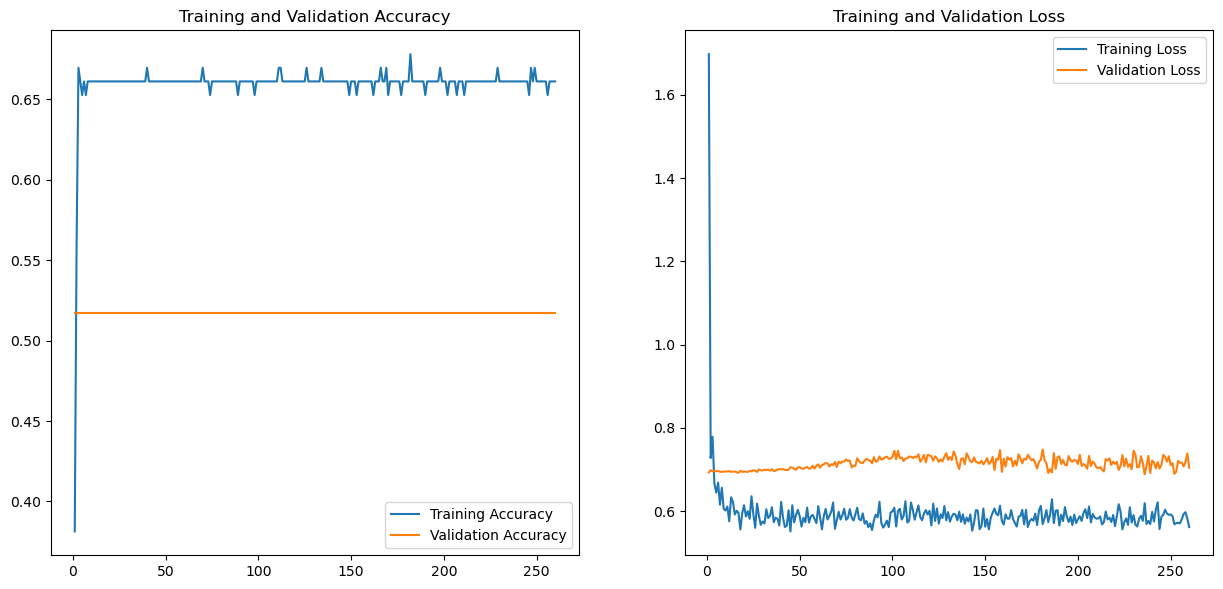

In [18]:
acc = train_o_aug.history['accuracy']
val_acc = train_o_aug.history['val_accuracy']
loss = train_o_aug.history['loss']
val_loss = train_o_aug.history['val_loss']

epochs_range = range(1, len(acc)+1)

#Train and validation accuracy 
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Train and validation loss 
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
acc_o = []
acc_o_aug = []
for i in range(10):
    
    _, val_acc = model_o.evaluate(X_val_o, Y_val_o, verbose=0)
    print('Validation accuracy: %.3f' % (val_acc))
    acc_o.append(val_acc)

    _, val_acc = model_o_aug.evaluate(aug_val_o, verbose=0)
    print('Validation accuracy: %.3f' % (val_acc))
    acc_o_aug.append(val_acc)

Validation accuracy: 0.567
Validation accuracy: 0.517
Validation accuracy: 0.567
Validation accuracy: 0.517
Validation accuracy: 0.567
Validation accuracy: 0.517
Validation accuracy: 0.567
Validation accuracy: 0.517
Validation accuracy: 0.567
Validation accuracy: 0.517
Validation accuracy: 0.567
Validation accuracy: 0.517
Validation accuracy: 0.567
Validation accuracy: 0.517
Validation accuracy: 0.567
Validation accuracy: 0.517
Validation accuracy: 0.567
Validation accuracy: 0.517
Validation accuracy: 0.567
Validation accuracy: 0.517


In [20]:
media_o = np.mean(acc_o)
std_o = np.std(acc_o)
print(media_o)
print(std_o)

0.5666666626930237
0.0


In [21]:
media_o_aug = np.mean(acc_o_aug)
std_o_aug = np.std(acc_o_aug)
print(media_o_aug)
print(std_o_aug)

0.517241358757019
0.0


In [22]:
mammo_o_t, mammo_f_t, label_t = [], [], []
data_folder_t = "../test_dataset/"
os.chdir(data_folder_t)
l_t = os.listdir()

In [23]:
def create_dataset_t(lista, o_img, f_img, labels):
    #Function calling the Matlab file in order to filter the images.
    for element in lista:
        if "_1_resized.pgm" in element:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(data_folder_t, element)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            labels.append(1)
        elif "_2_resized.pgm" in element:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(data_folder_t, element)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            labels.append(0)

In [24]:
os.chdir("./")
threads = []
chunk = 6

for i in range(5):
    t = thr.Thread(target = create_dataset_t, args = (l_t[i*chunk : (i+1)*chunk], mammo_o_t, mammo_f_t, label_t))
    threads.append(t)
    t.start()
    
for j in threads:
    j.join()

In [25]:
eng.quit()

In [26]:
mammo_o_t = np.asarray(mammo_o_t, dtype = 'float32')/255.
mammo_f_t = np.asarray(mammo_f_t, dtype = 'float32')/255.
label_t = np.asarray(label_t)
mammo_o_4d_t = np.reshape(mammo_o_t, (30, 125, 125, 1))
print(mammo_o_4d_t.shape)
mammo_f_4d_t = np.reshape(mammo_f_t, (30, 64, 64, 1))
print(mammo_f_4d_t.shape)

ValueError: cannot reshape array of size 234375 into shape (30,125,125,1)

In [ ]:
if media_o > media_o_aug:
    model_test = model_o()
else:
    model_test = model_o_aug()

In [ ]:
test_loss, test_acc = model.evaluate(mammo_o_4d_t, label_t)
preds_test = model_test.predict(mammo_o_4d_t, verbose=1)
fpr, tpr, _ = roc_curve(label_t, preds_test)
roc_auc = auc(fpr, tpr)

print('\n Test accuracy = %.3f'% (test_acc))
print('\n AUC = %.3f'% (roc_auc))